<a href="https://colab.research.google.com/github/anirudh-g/Msc-Data-science/blob/master/Chart_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1> SETUP </H1>

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
#For now - 4 classes: Area chart, Bar chart, pie chart, scatter plot. 100 images per class. 80/20 train/val split
train_dir = '/content/drive/My Drive/Colab Notebooks/Train'
validation_dir = '/content/drive/My Drive/Colab Notebooks/Validation'

<H1>BASELINE MODEL</H1>

In [18]:
#List of all basic tunable parameters of the model - to be updated
img_width, img_height = 150, 150
nb_train_samples = 80
nb_validation_samples = 20
epochs = 20
batch_size = 10

In [19]:
#checking whether the rgb channel is first or last to feed the input shape accordingly
if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3) 

# 3 CNN blocks containing a max pooling layer in each of them. On top of that is a fully connected layer with relu activation function
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(4, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 20736)            

In [20]:
#Performing augmentation on image scaling, zoom and fliiping the images horizontally so that the network has more training samples
train_datagen = ImageDataGenerator( 
	rescale=1. / 255, 
	shear_range=0.2, 
	zoom_range=0.2, 
	horizontal_flip=True) 

#Not having any augmentation apart from scaling as the validation data should resemble the real-world data as close as possible
val_datagen = ImageDataGenerator(rescale=1. / 255) 

train_generator = train_datagen.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical') 

validation_generator = val_datagen.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical') 

history = model.fit( 
	train_generator, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 


Found 320 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Epoch 1/20
8/8 [==============================] - 3s 404ms/step - loss: 1.8803 - accuracy: 0.3250 - val_loss: 1.2089 - val_accuracy: 0.4500
Epoch 2/20
8/8 [==============================] - 3s 369ms/step - loss: 1.3075 - accuracy: 0.3625 - val_loss: 1.4537 - val_accuracy: 0.3000
Epoch 3/20
8/8 [==============================] - 3s 376ms/step - loss: 1.4036 - accuracy: 0.3500 - val_loss: 1.2116 - val_accuracy: 0.4500
Epoch 4/20
8/8 [==============================] - 3s 365ms/step - loss: 1.0916 - accuracy: 0.6125 - val_loss: 0.9540 - val_accuracy: 0.6500
Epoch 5/20
8/8 [==============================] - 3s 366ms/step - loss: 0.8654 - accuracy: 0.7375 - val_loss: 1.0404 - val_accuracy: 0.5500
Epoch 6/20
8/8 [==============================] - 3s 384ms/step - loss: 0.9407 - accuracy: 0.5875 - val_loss: 0.8839 - val_accuracy: 0.6000
Epoch 7/20
8/8 [==============================] - 3s 378ms/step - loss: 0.7349 

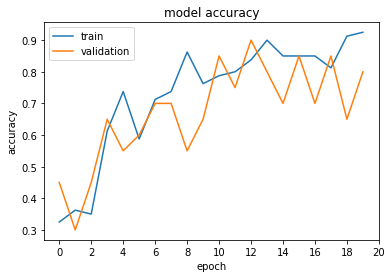

In [21]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,21, 2))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

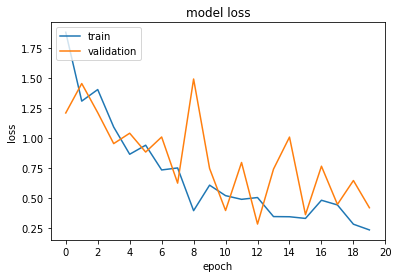

In [22]:
# summarize history for loss https://www.kaggle.com/prateek0x/multiclass-image-classification-using-keras
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,21, 2))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [23]:
print(validation_generator.class_indices)

{'AreaChart': 0, 'BarChart': 1, 'PieChart': 2, 'ScatterPlot': 3}
